In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf



## Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic #Holistic model
mp_drawing = mp.solutions.drawing_utils #Drawing utilies

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable 
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable      
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR CONVERSION RGB 2 BGR
    return image, results

In [4]:
#from mediapipe.python.solutions.face_mesh_connections import FACEMESH_TESSELATION
#from mediapipe.python.solutions.hands_connections import HAND_CONNECTIONS
#from mediapipe.python.solutions.pose_connections import POSE_CONNECTIONS

In [5]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)   

In [6]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness = 1, circle_radius = 1),
                             mp_drawing.DrawingSpec(color=(256,256,256), thickness = 1, circle_radius = 1))
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness = 2, circle_radius = 4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness = 2, circle_radius = 2))
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness = 2, circle_radius = 4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness = 2, circle_radius = 2))
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness = 2, circle_radius = 4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness = 2, circle_radius = 2))


In [7]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

### Preprocess Data and Create Labels and Features

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [10]:
#demo_actions = np.array(['A', 'B', 'C', 'H', 'I'])

In [11]:
actions = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])

In [12]:
#actions = np.array(['A', 'B', 'C'])

In [13]:
len(actions)

26

In [14]:
#label_map = {label: num for num, label in enumerate(demo_actions)}

In [15]:
label_map = {label: num for num, label in enumerate(actions)}

In [16]:
label_map

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25}

In [17]:
#DATA_PATH = os.path.join('DemoData')

In [18]:
DATA_PATH = os.path.join('Data')

In [19]:
sequence_length = 30

In [20]:
""""sequences, labels = [], []
for action in demo_actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])"""

'"sequences, labels = [], []\nfor action in demo_actions:\n    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):\n        window = []\n        for frame_num in range(sequence_length):\n            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))\n            window.append(res)\n        sequences.append(window)\n        labels.append(label_map[action])'

In [21]:
%%time
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

Wall time: 16min 49s


In [22]:
np.array(sequences).shape

(1300, 30, 1662)

In [23]:
np.array(labels).shape

(1300,)

In [24]:
X = np.array(sequences)

In [25]:
X.shape

(1300, 30, 1662)

In [26]:
y = to_categorical(labels).astype(int)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.10, random_state = 42)

In [28]:
y_test.shape

(130, 26)

## Build and Train LSTM Neural Network

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [60]:
log_dir = os.path.join('logss')
tb_callback = TensorBoard(log_dir=log_dir)

In [30]:
model02=Sequential()
model02.add(LSTM(128,activation='relu',return_sequences=True, input_shape=(30,1662)))
model02.add(Dropout(0.2))
model02.add(LSTM(128, return_sequences=False, activation='relu'))
model02.add(Dropout(0.2))
model02.add(Dense(32, activation='relu'))
model02.add(Dropout(0.2))
model02.add(Dense(actions.shape[0], activation='softmax'))
model02.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model02.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 128)           916992    
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                8

In [62]:
%%time
model02.fit(X_train, y_train, epochs=200, callbacks=[tb_callback])

Epoch 1/170
37/37 [==============================] - 117s 463ms/step - loss: 5.7275 - accuracy: 0.0324 - loss: 5.7977 - accuracy: 0.
Epoch 2/170
37/37 [==============================] - 6s 170ms/step - loss: 3.2933 - accuracy: 0.0339
Epoch 3/170
37/37 [==============================] - 6s 160ms/step - loss: 3.2617 - accuracy: 0.0406
Epoch 4/170
37/37 [==============================] - 6s 169ms/step - loss: 3.2632 - accuracy: 0.0432
Epoch 5/170
37/37 [==============================] - 6s 159ms/step - loss: 3.2425 - accuracy: 0.0666
Epoch 6/170
37/37 [==============================] - 6s 161ms/step - loss: 3.3097 - accuracy: 0.0412
Epoch 7/170
37/37 [==============================] - 6s 168ms/step - loss: 3.2540 - accuracy: 0.0551
Epoch 8/170
37/37 [==============================] - 6s 159ms/step - loss: 3.2445 - accuracy: 0.0479
Epoch 9/170
37/37 [==============================] - 6s 169ms/step - loss: 3.2391 - accuracy: 0.0633
Epoch 10/170
37/37 [==============================] - 6s 16

## Making predictions

In [32]:
res = model02.predict(X_test)

In [33]:
actions[np.argmax(res[9])]

'C'

In [34]:
actions[np.argmax(y_test[9])]

'C'

## Saving Weights

In [52]:
model02.save('actions_model02.h5')

In [32]:
del model

In [31]:
model02.load_weights('actions_model02.h5')

## Evaluation using Confusion Matrix and Accuracy

In [35]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [36]:
yhat = model02.predict(X_test)

In [37]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [38]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[120,   5],
        [  1,   4]],

       [[122,   0],
        [  3,   5]],

       [[126,   2],
        [  0,   2]],

       [[126,   1],
        [  1,   2]],

       [[122,   0],
        [  2,   6]],

       [[124,   0],
        [  0,   6]],

       [[126,   2],
        [  0,   2]],

       [[126,   1],
        [  0,   3]],

       [[123,   2],
        [  1,   4]],

       [[121,   0],
        [  1,   8]],

       [[124,   2],
        [  0,   4]],

       [[125,   0],
        [  0,   5]],

       [[122,   0],
        [  0,   8]],

       [[125,   0],
        [  2,   3]],

       [[125,   0],
        [  2,   3]],

       [[129,   0],
        [  1,   0]],

       [[120,   2],
        [  0,   8]],

       [[125,   0],
        [  2,   3]],

       [[125,   0],
        [  1,   4]],

       [[127,   0],
        [  1,   2]],

       [[123,   0],
        [  2,   5]],

       [[121,   2],
        [  0,   7]],

       [[125,   1],
        [  1,   3]],

       [[125,   1],
        [  0, 

In [39]:
accuracy_score(ytrue, yhat)

0.8153846153846154

Text(0.5, 15.0, 'Predicted label')

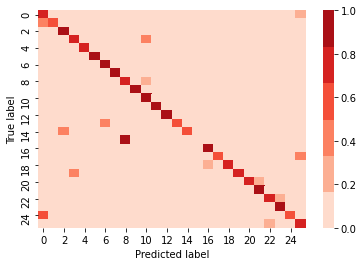

In [51]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(ytrue, yhat)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
colormap = sns.color_palette("Reds")
sns.heatmap(conf_mat_normalized, cmap= colormap)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt=‘’, cmap='Blues')

In [37]:
from sklearn import metrics

In [38]:
print(metrics.classification_report(ytrue, yhat, digits=3))

              precision    recall  f1-score   support

           0      0.571     0.800     0.667         5
           1      1.000     0.750     0.857         8
           2      0.500     1.000     0.667         2
           3      0.750     1.000     0.857         3
           4      1.000     0.875     0.933         8
           5      1.000     1.000     1.000         6
           6      1.000     0.500     0.667         2
           7      1.000     1.000     1.000         3
           8      0.800     0.800     0.800         5
           9      1.000     0.778     0.875         9
          10      1.000     1.000     1.000         4
          11      1.000     1.000     1.000         5
          12      0.875     0.875     0.875         8
          13      0.800     0.800     0.800         5
          14      1.000     0.800     0.889         5
          15      0.000     0.000     0.000         1
          16      1.000     1.000     1.000         8
          17      0.800    

## Test in Real Time

In [40]:
from scipy import stats

In [41]:
colors = [(245,117,16), (117,245,16), (16,117,245), (117,245,16), (117,245,16)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [48]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model02.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 10: 
                sentence = sentence[-10:]

            # Viz probabilities
            #image = prob_viz(res, demo_actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [45]:
cv2.destroyAllWindows()

In [46]:
cv2.destroyAllWindows()